(500, 1007, 3)


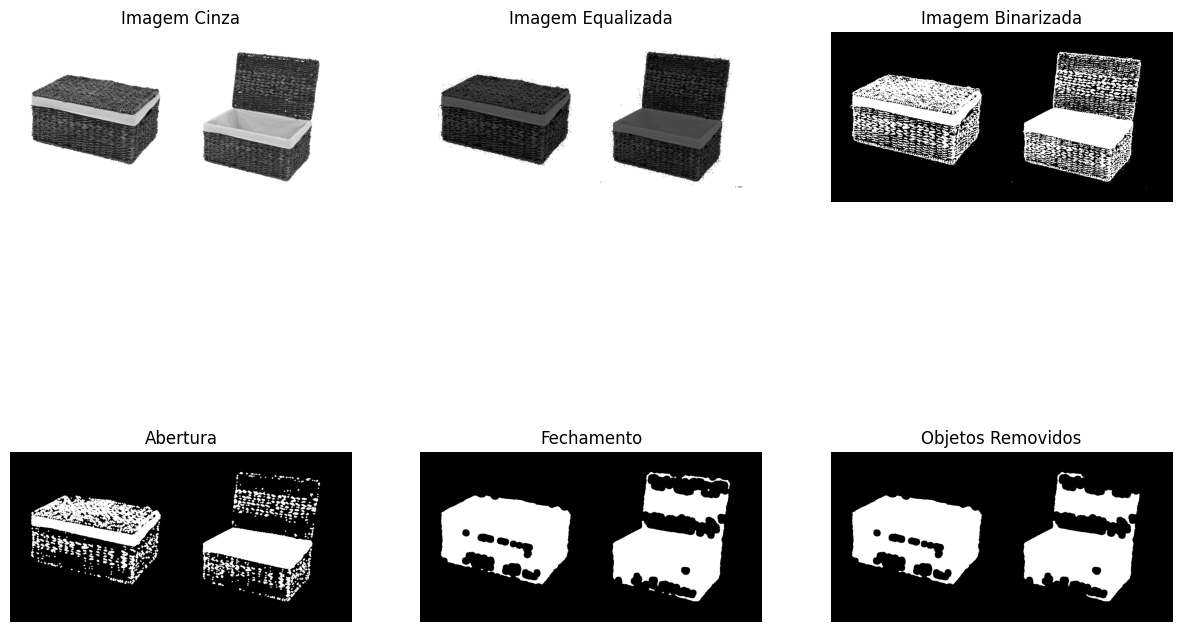

In [61]:
#SEM GAUSSIANO
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, morphology
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import opening, closing, remove_small_objects
from skimage.util import img_as_ubyte


# Função para exibir a imagem
def show_images(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 10))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(2, len(images) // 2, i + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Carregar a imagem
image_path = 'cesto.jpg'
image = io.imread(image_path)
# Verificar as dimensões da imagem
print(image.shape)
# Converter a imagem para escala de cinza
image_gray = color.rgb2gray(image,channel_axis=-1)


# Equalizar o histograma da imagem
image_equalized = exposure.equalize_hist(image_gray)

# Calcular o limiar usando o método de Otsu
thresh = threshold_otsu(image_equalized)

# Binarizar a imagem usando o limiar calculado

b2 = image_equalized < thresh
b1 = image_equalized > threshold_otsu(b2*image_equalized)
binary_image = b1 * b2


# Aplicar a operação de abertura
oelem = morphology.disk(2)  # Elemento estruturante 10
opened_image = opening(binary_image, oelem)

# Aplicar a operação de fechamento 14
celem = morphology.disk(10)
closed_image = closing(opened_image, celem)

# Remover pequenos objetos
cleaned_image = remove_small_objects(closed_image, min_size=10000)

# Converter para formato uint8 para exibição

binary_image_uint8 = img_as_ubyte(binary_image)
opened_image_uint8 = img_as_ubyte(opened_image)
closed_image_uint8 = img_as_ubyte(closed_image)
cleaned_image_uint8 = img_as_ubyte(cleaned_image)

# Exibir as imagens
show_images(
    [image_gray , image_equalized, binary_image_uint8, opened_image_uint8, closed_image_uint8, cleaned_image_uint8],
    ['Imagem Cinza','Imagem Equalizada', 'Imagem Binarizada', 'Abertura', 'Fechamento', 'Objetos Removidos']
)






(562, 2942, 3)


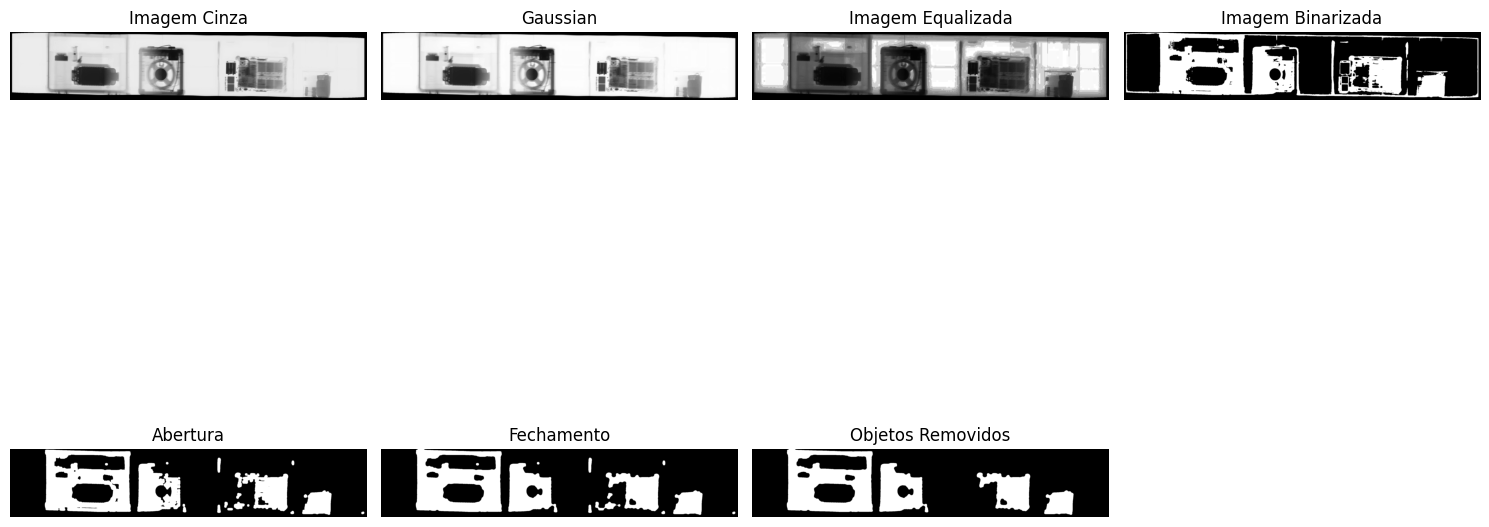

In [68]:
#COM GAUSSIANO
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, morphology
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import opening, closing, remove_small_objects
from skimage.util import img_as_ubyte

# Função para exibir a imagem
def show_images(images, titles, cmap='gray'):
    n = len(images)
    cols = 4  # Definindo um número fixo de colunas para a grade
    rows = (n + cols - 1) // cols  # Calculando o número de linhas necessário
    plt.figure(figsize=(15, 5 * rows))
    
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Carregar a imagem
image_path = 'xray.jpg'
image = io.imread(image_path)
# Verificar as dimensões da imagem
print(image.shape)
# Converter a imagem para escala de cinza
image_gray = color.rgb2gray(image, channel_axis=-1)

# Aplicar filtro Gaussiano
gaussian_filtered = gaussian(image_gray, sigma=1)

# Equalizar o histograma da imagem
image_equalized = exposure.equalize_hist(gaussian_filtered)

# Calcular o limiar usando o método de Otsu
thresh = threshold_otsu(image_equalized)

# Binarizar a imagem usando o limiar calculado
b2 = image_equalized < thresh
b1 = image_equalized > threshold_otsu(b2*image_equalized)
binary_image = b1 * b2


# Aplicar a operação de abertura
oelem = morphology.disk(10)  # Elemento estruturante 10
opened_image = opening(binary_image, oelem)

# Aplicar a operação de fechamento 14
celem = morphology.disk(14)
closed_image = closing(opened_image, celem)

# Remover pequenos objetos
cleaned_image = remove_small_objects(closed_image, min_size=10000)

# Converter para formato uint8 para exibição
binary_image_uint8 = img_as_ubyte(binary_image)
opened_image_uint8 = img_as_ubyte(opened_image)
closed_image_uint8 = img_as_ubyte(closed_image)
cleaned_image_uint8 = img_as_ubyte(cleaned_image)

# Exibir as imagens
show_images(
    [image_gray, gaussian_filtered, image_equalized, binary_image_uint8, 
     opened_image_uint8, closed_image_uint8, cleaned_image_uint8],
    ['Imagem Cinza', 'Gaussian', 'Imagem Equalizada', 'Imagem Binarizada', 
     'Abertura', 'Fechamento', 'Objetos Removidos']
)


In [69]:
# Segmentação
def segmentation(binary_image):
    labels = np.zeros(binary_image.shape)

    n_lines = binary_image.shape[0]
    n_columns = binary_image.shape[1]
   
    for l in range(n_lines):
        for c in range(n_columns):
            if binary_image[l,c] == 0:
                labels[l,c] = 0
                continue
           
            viz1 = labels[l-1][c] if l > 0 and l <= n_lines else 0 #vizinho de cima
            viz2 = labels[l-1][c-1] if 0 < l <=n_lines and 0 < c <= n_columns  else 0 # vizinho diagonal esquerda acima \
            viz3 = labels[l][c-1] if 0 < c <= n_columns  else 0 #vizinho da esquerda
            viz4 = labels[l-1][c+1] if 0 < l <=n_lines and 0 < c <= n_columns else 0 # vizinho diagonal direita acima /

            neighs = {viz1, viz2, viz3, viz4}
            neighs.discard(0) #remove elementos 0 (pixels invalidos) do conjunto

            neights_list = list(neighs) #coverte o objeto neighs iteravél em uma lista

            if (len(neights_list) == 0): #se não tiver nenhum vizinho rotulado, cria um novo rotulo
                labels[l,c] = np.max(labels) + 1

            elif (len(neights_list) == 1): 
                labels[l,c] = neights_list[0]
            else:
                min_neigh = min(neighs) #com mais de um vizinho rotulado, pega o menor rotulo, e atribui ao pixel e seus vizinhos
                for neigh in neighs:
                    labels[labels == neigh] = min_neigh

    return labels

segm = segmentation(cleaned_image_uint8)


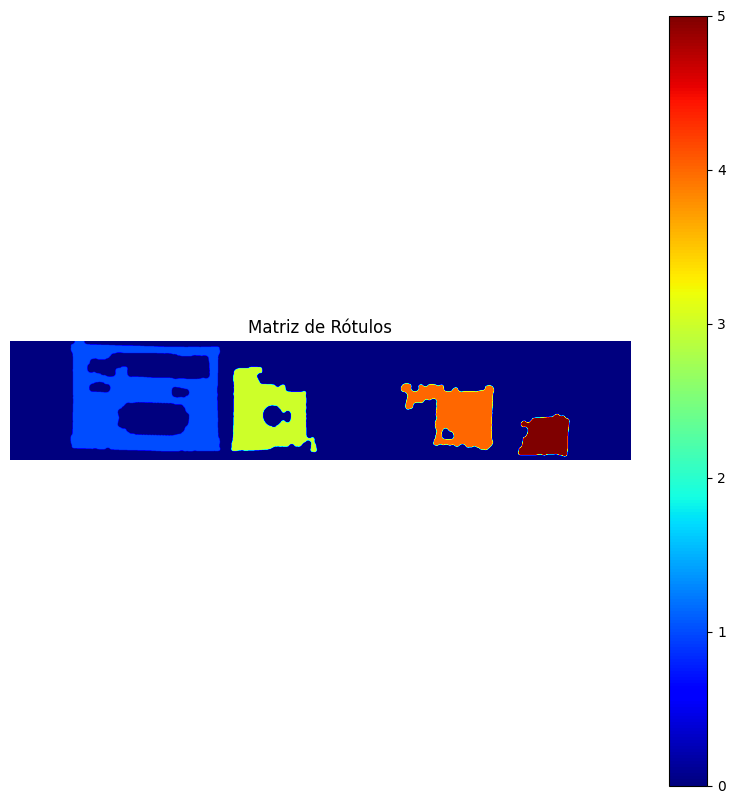

In [70]:
# Exibir a imagem rotulada
plt.figure(figsize=(10, 10))
plt.imshow(segm, cmap='jet')
plt.colorbar()
plt.title('Matriz de Rótulos')
plt.axis('off')
plt.show()

[1. 3. 4. 5.]


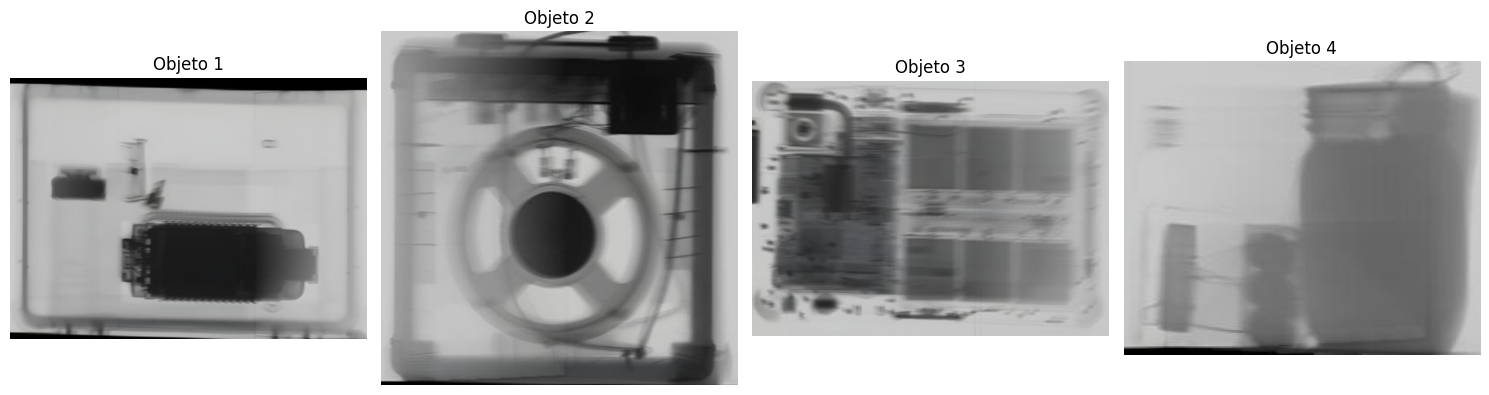

In [71]:
import os
from skimage.io import imsave

# Verificar se o diretório 'output' existe, caso contrário, criá-lo
output_dir = 'resultados'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extrair e salvar imagens
regions = np.unique(segm)[1:]  # Ignora o fundo (índice 0)
print(regions)
num_regions = len(regions)
fig, axes = plt.subplots(1, num_regions, figsize=(15, 5))

for i, region in enumerate(regions):
    coords = np.argwhere(segm == region)

    # Verificar se coords está vazio
    if coords.size == 0:
        continue

    min_x, min_y = np.min(coords, axis=0)
    max_x, max_y = np.max(coords, axis=0)

    # Verificar se os limites são válidos
    if min_x < max_x and min_y < max_y:
        region_image = image[min_x:max_x, min_y:max_y]

        # Salvar a imagem da região
        imsave(f"{output_dir}/object_{i+1}.png", region_image)

        axes[i].imshow(region_image)
        axes[i].set_title(f'Objeto {i+1}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()


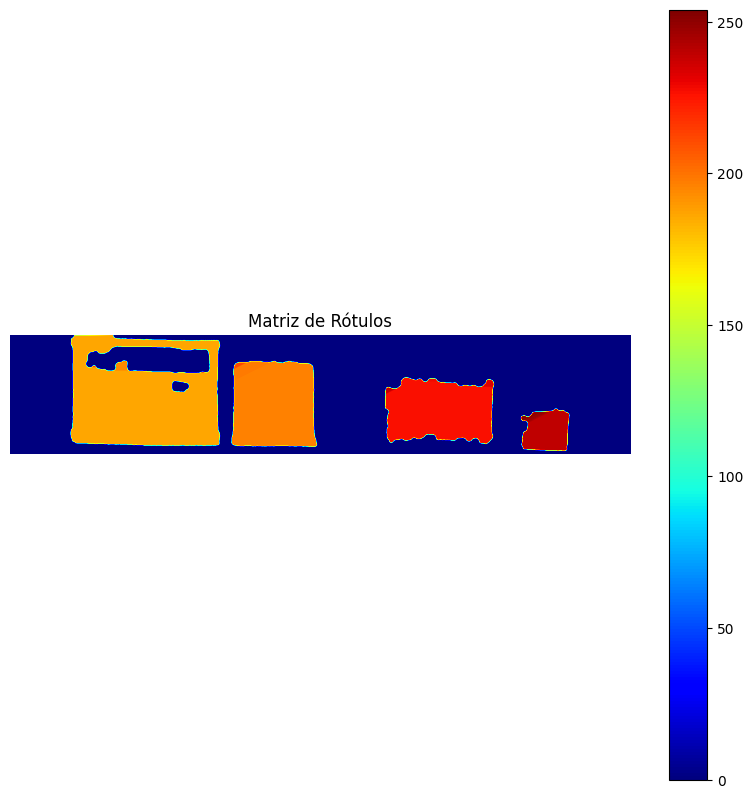

In [109]:
def connected_component_labeling(binary_image):
    # Pegando as dimensões da imagem
    height, width = binary_image.shape

    # Inicializando a matriz de rótulos com zeros
    labels = np.zeros(binary_image.shape,int)
   
    # Inicializando o contador de rótulos
    current_label = 1

    # Função para verificar se um pixel é válido (dentro dos limites da imagem)
    def is_valid(x, y):
      return 0 < x <= height and 0 < y <= width 

    # Percorrendo a imagem pixel por pixel
    for i in range(height):
        for j in range(width):
            if binary_image[i, j] == 0 :
              labels[i,j] = 0
              continue

            # Lista para armazenar os rótulos dos vizinhos válidos
            neighbor_labels = []

            # Vizinhos: direita (j+1), acima (i-1, j), diagonal direita-acima (i-1, j+1), diagonal esquerda-acima (i-1, j-1)
            neighbors = [
                (i-1, j-1), (i-1, j), (i-1, j+1), # Vizinhos da linha acima
                (i, j-1)         # Vizinhos da linha atual
                
            ]
            
            for ni, nj in neighbors:
                  if is_valid(ni, nj) and labels[ni, nj] != 0 :
                      neighbor_labels.append(labels[ni, nj])

            
            if (len(neighbor_labels) > 0):
                # Se existir um ou mais vizinho rotulado, pegue o menor rótulo
                min_label = min(neighbor_labels)
                labels[i, j] = min_label

                # Atualizar todos os vizinhos com o menor rótulo
                for ni, nj in neighbors:
                     if labels[ni, nj] in neighbor_labels:
                         labels[ni, nj] = min_label
            else:
                # Caso contrário, assigne um novo rótulo
                labels[i, j] = np.max(labels) + 1
                

    return labels

test = connected_component_labeling(cleaned_image_uint8)
# Exibir a imagem rotulada
plt.figure(figsize=(10, 10))
plt.imshow(test, cmap='jet')
plt.colorbar()
plt.title('Matriz de Rótulos')
plt.axis('off')
plt.show()